## Imports

Please install any moduals listed here that you do not already have installed

In [2]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Global Variables


In [3]:
# Paths to data files (images and meta data i.e. labels)
PROJECT_PATH   = '.'
META_DATA_PATH = f'{PROJECT_PATH}/data/train-metadata.csv'
IMAGE_DIR      = f'{PROJECT_PATH}/data/train-image/image/'

# Image file extention
IMAGE_FILE_EXT = '.jpg' 

DATA_SUBSET    = 100

## Data Loading and Preproscessing

- It is assumed that the required data has been downloaded from https://www.kaggle.com/datasets/nischaydnk/isic-2020-jpg-256x256-resized and has been placed into the "./data/" directory
- We will then load in the images and lables from this directory
- To load in the images we will use 'imread' and then preform preprocessing to normalise and resize the samples

In [4]:
# Load the metadata file
metadata = pd.read_csv(META_DATA_PATH)

# Add the file extension to isic_id to match image filenames
metadata['image_file'] = metadata['isic_id'] + IMAGE_FILE_EXT

# Create a dictionary to map image filename to target class
image_to_label = dict(zip(metadata['image_file'], metadata['target']))

# Directory containing images
image_paths = [os.path.join(IMAGE_DIR, img) for img in os.listdir(IMAGE_DIR) if img in image_to_label]

# Check if all images were found in the metadata
print(f"Found {len(image_paths)} images out of {len(metadata)} labels in the metadata.")

Found 33126 images out of 33126 labels in the metadata.


In [5]:
# TESTING PURPOSES: use only a subset of the data
image_paths = image_paths[:DATA_SUBSET]

In [6]:
# Resize and normalize the images
def preprocess_images(paths, img_size=(256, 256)):
    images = []
    labels = []
    for path in paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            images.append(img)
            
            # Get the corresponding label for this image
            img_name = os.path.basename(path)
            labels.append(image_to_label[img_name])
    return np.array(images), np.array(labels)

# Preprocess the images and get labels
images, labels = preprocess_images(image_paths)

## Explortatory Analysis

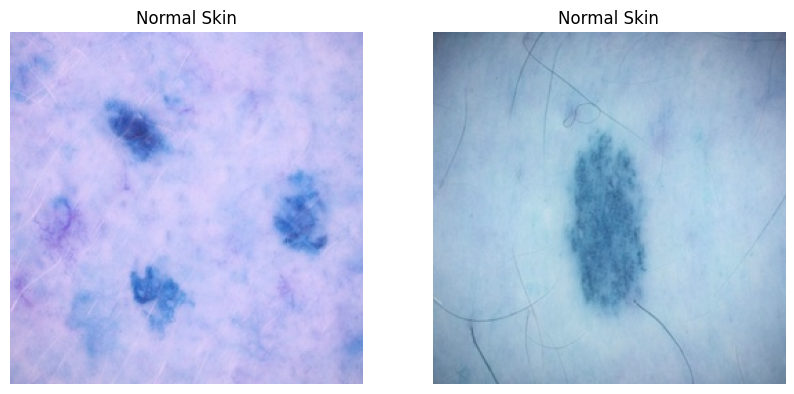

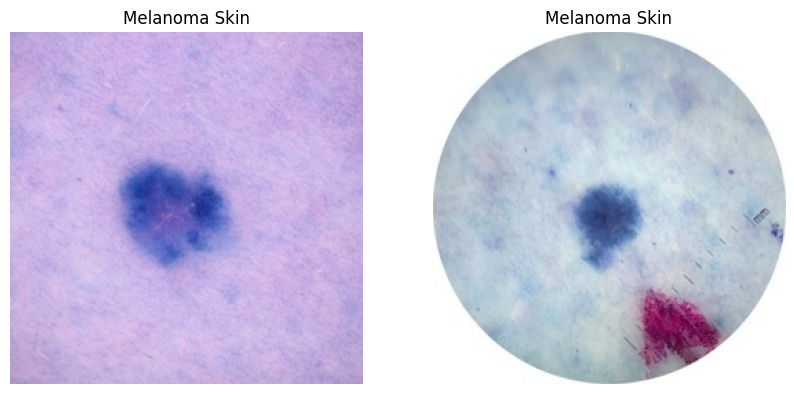

In [7]:
# Function to display images
def display_images(images, title, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(title)
        plt.axis('off')
    plt.show()

# Select 5 images from each class (normal and melanoma)
normal_images = images[labels == 0][:2]  # Assuming 0 is for normal skin
melanoma_images = images[labels == 1][:2]  # Assuming 1 is for melanoma

# Display images from both classes
display_images(normal_images, title="Normal Skin", num_images=2)
display_images(melanoma_images, title="Melanoma Skin", num_images=2)


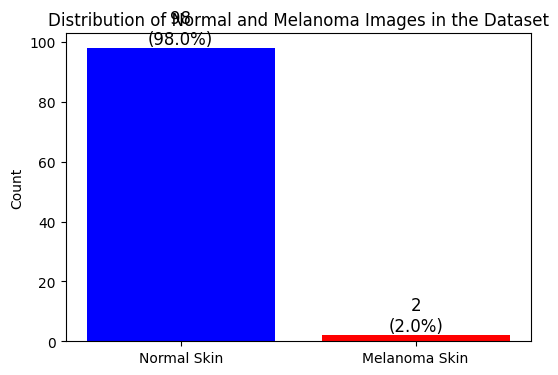

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Count occurrences of each class (0: normal, 1: melanoma)
unique, counts = np.unique(labels, return_counts=True)

# Calculate percentages
total = np.sum(counts)
percentages = counts / total * 100

# Plot the bar graph
plt.figure(figsize=(6, 4))
bars = plt.bar(unique, counts, color=['blue', 'red'])
plt.xticks([0, 1], ['Normal Skin', 'Melanoma Skin'])
plt.ylabel('Count')
plt.title('Distribution of Normal and Melanoma Images in the Dataset')

# Add count and percent on top of the bars
for bar, count, percent in zip(bars, counts, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(count)}\n({percent:.1f}%)', 
             ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()


In [9]:
import pandas as pd
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN
from collections import Counter


# Check the original class distribution
print("Original class distribution:", Counter(labels))

# Step 2: Instantiate ADASYN
adasyn = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)

# Step 3: Fit and resample
images, labels = adasyn.fit_resample(images.reshape(images.shape[0], -1), labels)
images = images.reshape(-1, 256, 256, 3)

# Check the new class distribution
print("Resampled class distribution:", Counter(labels))
print(len(images))
print(len(labels))

Original class distribution: Counter({0: 98, 1: 2})
Resampled class distribution: Counter({0: 98, 1: 98})
196
196


## Data Train Test Split

In [10]:
# Split the data into training and test sets
# Use stratified sampling to ensure classes are split evenly between the sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

print(test_labels)

[0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 1
 0 0 1]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Original class distribution:", Counter(train_labels))

# Count number of samples in each class in the training set
class_0_count = np.sum(train_labels == 0)
class_1_count = np.sum(train_labels == 1)

# Number of samples we need to generate for class 1
num_samples_needed = class_0_count - class_1_count

# Extract class 1 samples for augmentation
class_1_images = train_images[train_labels == 1]

# Set up the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,     # Rotate the image randomly
    width_shift_range=0.2, # Shift image horizontally
    height_shift_range=0.2, # Shift image vertically
    shear_range=0.2,       # Shear transformation
    zoom_range=0.2,        # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'    # Fill mode for transformed images
)

# Generate augmented images
augmented_images = []
augmented_labels = []

for i, img in enumerate(class_1_images):
    # Generate num_samples_needed per image
    augmented = datagen.flow(np.expand_dims(img, axis=0), batch_size=1)
    for j in range(num_samples_needed // len(class_1_images) + 1):
        augmented_images.append(next(augmented)[0])
        augmented_labels.append(1)  # Label for class 1

# Convert augmented data to numpy arrays
augmented_images = np.array(augmented_images[:num_samples_needed])
augmented_labels = np.array(augmented_labels[:num_samples_needed])

# Combine the original training set with the augmented samples
train_images = np.concatenate((train_images, augmented_images), axis=0)
train_labels = np.concatenate((train_labels, augmented_labels), axis=0)

print("Resampled class distribution:", Counter(train_labels))

## Create Triplets

In [11]:
import random
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader


class TripletDataGenerator(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        # self.to_pil = transforms.ToPILImage()
    
        self.images = images           
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, anchor_idx):
        anchor_img = self.images[anchor_idx]#.reshape(256, 256, 3)
        
        if self.is_train:
            anchor_label = self.labels[anchor_idx]

            positive_list = [idx for idx, label in enumerate(self.labels) if label == anchor_label and idx != anchor_idx]
            # print(f"{positive_list=}")
            positive_idx = random.choice(positive_list)
            positive_img = self.images[positive_idx]#.reshape(256, 256, 3)
            
            negative_list = [idx for idx, label in enumerate(self.labels) if label != anchor_label and idx != anchor_idx]
            negative_idx = random.choice(negative_list)
            negative_img = self.images[negative_idx]#.reshape(256, 256, 3)
            
            if self.transform:
                # anchor_img = self.transform(self.to_pil(anchor_img))
                # positive_img = self.transform(self.to_pil(positive_img))
                # negative_img = self.transform(self.to_pil(negative_img))
                anchor_img = self.transform(anchor_img)
                positive_img = self.transform(positive_img)
                negative_img = self.transform(negative_img)
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                # anchor_img = self.transform(self.to_pil(anchor_img))
                anchor_img = self.transform(anchor_img)
            return anchor_img
        
### TODO: Update so that members to triplets obey the distance rules mentioned in slides

In [12]:
from albumentations.pytorch import ToTensorV2  # Import ToTensorV2 from Albumentations


train_ds = TripletDataGenerator(
    images=train_images,
    labels=train_labels,
    train=True, 
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert from NumPy array to PIL Image
        transforms.RandomRotation(degrees=10, fill=(255, 255, 255)),  # Rotation with 20-degree range and fill mode
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10, fill=(255, 255, 255)),  # Horizontal and vertical shift and shear
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Random zoom (resize crop with scaling)
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),  # Convert back to Tensor
#         transforms.Normalize(
#             mean=[0.485, 0.456, 0.406], 
#             std=[0.229, 0.224, 0.225]
#         ),
    ])
)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_ds = TripletDataGenerator(
    images=test_images,
    labels=test_labels,
    train=True,
    transform=transforms.Compose([
        #transforms.ToPILImage(),
        transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.485, 0.456, 0.406], 
#             std=[0.229, 0.224, 0.225]
#         ),
    ])
)
val_loader = DataLoader(val_ds, batch_size=320, shuffle=True, num_workers=4)

test_ds = TripletDataGenerator(
    images=test_images,
    labels=test_labels,
    train=False,
    transform=transforms.Compose([
        #transforms.ToPILImage(),
#         transforms.Normalize(
#             mean=[0.485, 0.456, 0.406], 
#             std=[0.229, 0.224, 0.225]
#         ),
        transforms.ToTensor()
    ])
)
test_loader = DataLoader(test_ds, batch_size=320, shuffle=True, num_workers=4)

(256, 256, 3)


In [13]:
# Now you can use next() to get a sample
# Get a single sample
for anc, pos, neg, label in train_loader:
    single_sample = anc[0]  # Get the first sample from the batch
    single_label = label[0]  # Get the corresponding label
    break  # Exit after getting the first sample

print("Single sample:", single_sample.size())
print("Single label:", single_label)


Single sample: torch.Size([256, 256, 3])
Single label: tensor(0)


## Triplet Loss

In [14]:
import torch.nn as nn


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Basic Network

In [15]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True, drop_rate=0.5)

        # Adding a dropout layer before the final classifier
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Adding a dropout layer
            nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_dim)
        )

        
    def forward(self, images):
        return self.efficientnet(images)

In [16]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [18]:
embedding_dims = 2
batch_size = 32
epochs = 50

import torch.optim as optim

model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

: 

## Training

In [19]:

model.train()
for epoch in range(epochs):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(train_loader):
        # print(step)
        # print(anchor_label)

        # display_images([anchor_img[0], positive_img[0], negative_img[0]], title="Normal Skin", num_images=3)
        # break
        print(step)

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        # Convert inputs to float32 before passing to the model
        anchor_img = anchor_img.permute(0, 3, 1, 2).float()
        positive_img = positive_img.permute(0, 3, 1, 2).float()
        negative_img = negative_img.permute(0, 3, 1, 2).float()
                
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

0
1


## Model Evaluation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=6)  # You can adjust n_neighbors as needed

# Fit the model
knn.fit(train_results, labels)

# Predict on the test set
y_pred = knn.predict(pred_test_results)

print(y_pred)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)

# Get predicted probabilities
y_pred_proba = knn.predict_proba(pred_test_results)

# Calculate AUC-ROC score (for binary classification)
auc_roc = roc_auc_score(test_labels, y_pred_proba[:, 1])  # Probability of positive class
print("AUC-ROC:", auc_roc)